In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl

import copy


import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import pyTMD
import numpy as np
        
import pyTMD.io
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import timescale.time

np.float_ = np.float64
import dascore as dc

import seaborn as sns

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


    fs = attrs['PulseRate'] #sample rate
    bp_top = 200
    bp_bottom = 1
    downsample_rate = int(fs/bp_top)

    #filter by freq
    sos = signal.butter(10, [bp_bottom,bp_top], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)

    #FK filter
    new_format_times = time_fixer_4_fk(times)
    dims = ('time', 'distance')
    patch = dc.Patch(data=filtered, coords=dict(time=[np.datetime64(i) for i in new_format_times], distance=x), dims=dims)
    filt_cutoffs = np.array([0, 400, 8000, np.inf])

    fk_filtered = patch.slope_filter(filt=filt_cutoffs)
    fk_filtered_data = np.array(fk_filtered.data)


    #normalize
    data_normed_filtered = chan_norm(fk_filtered_data)

    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)
    # print(filled_data.shape)
    # print(first_filler.shape)
    filled_data = np.zeros((int(fs*60),data_normed_filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)




    if data_locator[0]==0:
        filled_data[data_locator] = data_normed_filtered

    else:
        first_filler = np.array([data_normed_filtered[:,0]]*data_locator[0])
        filled_data[:first_filler.shape[0],:] = first_filler
    
    filt_filled_data = filled_data

    filled_times[data_locator] = times
    # filled_data[data_locator] = data_normed_filtered.T

    # filt_filled_data = filled_data

    ## Downsample 
    filled_times = filled_times[::downsample_rate]
    filt_filled_data = filt_filled_data[::downsample_rate,::5] #Skip every 5th channel
    new_dict = dict(attrs)
    new_dict['PulseRate'] = new_dict['PulseRate']/downsample_rate


    return filt_filled_data, filled_times, new_dict

def foo(a):
    t = mdates.num2date(a)
    ms = str(t.microsecond)[:1]
    res = f"{t.hour:02}:{t.minute:02}:{t.second:02}.{ms}"
    return res

def chan_norm(das_data):
    data_normed = (das_data - np.mean(das_data, axis=0))/np.std(das_data, axis=0).T
    # data_normed_all_axis = (data_normed.T - np.mean(data_normed, axis=1))/np.std(data_normed, axis=1)   

    return data_normed

class DataStats:
    def __init__(self, data, attrs, times):
        self.sampling_rate = attrs["PulseRate"]
        self.npts = data.shape[0]
        self.starttime = times[0]
        # self.starttime.isoformat

class DAS:
    def __init__(self, id, data, attrs, times):
        self.id = id
        self.data = data
        self.stats = DataStats(data, attrs, times)


def obspy_stream_from_das(data, attrs,times):
    stats_default = {
        'network':'eastwind',
        'station':'',
        'location':'',
        'channel':'DAS',
        'starttime':times[0].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'endtime':times[-1].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'sampling_rate':attrs['PulseRate'],
        'delta':1/attrs['PulseRate'],
        'npts':0,
        'calib':1.0
    }

    streams = []
    for n,i in enumerate(data.T):
        tr = obspy.Trace(data=i,header=stats_default)
        # tr.stats.station = f'Channel {n}'
        tr.stats.npts = len(i)

        st = obspy.Stream(tr)
        streams.append(st)
    return streams

def parallel_event_finding(dummy):
    times_all,attrs,channel,all_data = dummy
    trigger_on=3.5, 
    trigger_off=1.2
    
    DAS_channel = DAS(channel, all_data, attrs, times_all)


    cft = recursive_sta_lta(DAS_channel.data, int(1 * attrs['PulseRate']), int(10 * attrs['PulseRate']))
    trigger_times = trigger_onset(cft, trigger_on, trigger_off)
    trigger_times_list = [trigger_times]     

    trigger_times_list_datetime = []

    for trigs_samp_time in trigger_times_list:
        trigger_times_list_datetime.append(times_all[trigs_samp_time])
    return {str(channel): trigger_times_list_datetime}


def time_fixer_4_fk(times):
    times_copy = times.copy()
    new_format_times = []
    for i in times_copy:
        if round(i.microsecond/500)*500 == 1000000:
            microsecond = 0
            second = i.second + 1
            minute = i.minute
            hour = i.hour
            day = i.day
            if second == 60:
                second = 0
                minute = minute+1

            if minute == 60:
                minute = 0
                hour=hour+1
            
            if hour == 24:
                hour = 0
                day = day+1
            
        else:
            microsecond = int(round(i.microsecond/500)*500)
            second = i.second
            minute = i.minute
            hour = i.hour
            day = i.day

        new_format_times.append(datetime.datetime(year=i.year,
                                                month=i.month,
                                                day=day,
                                                hour=hour,
                                                minute=minute,
                                                second=second,
                                                microsecond=microsecond))
    return new_format_times


import pathlib



import pandas as pd
from obspy import UTCDateTime
from obspy.clients.fdsn.mass_downloader import (
    GlobalDomain,
    Restrictions,
    MassDownloader,
)
from obspy.core import AttribDict
from pyproj import Proj
from multiprocessing import Pool

from quakemigrate import QuakeScan, Trigger
from quakemigrate.io import Archive, read_stations
from quakemigrate.lut import compute_traveltimes
from quakemigrate.signal.onsets import STALTAOnset
from quakemigrate.signal.pickers import GaussianPicker

import emcee
%matplotlib widget

In [2]:
channel_locations = np.array(pd.read_csv('cable_geometry/Eastwind_channel_locations.txt', sep=' ', header=None))

In [3]:
gpkg_path = 'imagery/eastwind_image_reproject_AOI_clip.tif'

# Open the GeoPackage file in read mode
with rasterio.open(gpkg_path) as src:
    # Read the image data as a NumPy array
    image_data = src.read()

    # Access metadata if needed
    metadata = src.meta

In [4]:


data_start1 = datetime.datetime(year=2024, 
                                month=12, 
                                day=18, 
                                hour=4, 
                                minute=54, tzinfo=datetime.timezone.utc).timestamp()

data_end1 = datetime.datetime(year=2024, 
                                month=12, 
                                day=18, 
                                hour=11, 
                                minute=19, tzinfo=datetime.timezone.utc).timestamp()

data_start2 = datetime.datetime(year=2024, 
                                month=12, 
                                day=18, 
                                hour=23, 
                                minute=7, tzinfo=datetime.timezone.utc).timestamp()

data_end2 = datetime.datetime(year=2024, 
                                month=12, 
                                day=19, 
                                hour=5, 
                                minute=16, tzinfo=datetime.timezone.utc).timestamp()

first_chunk_bounds = np.linspace(data_start1,data_end1,5)
second_chunk_bounds = np.linspace(data_start2,data_end2,5)

bounds = np.array([first_chunk_bounds,second_chunk_bounds]).flatten()

In [5]:
with open('event_locations/good_event_locations.pkl', 'rb') as f:
    all_locations_good = pkl.load(f)
mean_params_good = np.mean(np.array(list(all_locations_good.values())),axis=1)
std_params_good = np.std(np.array(list(all_locations_good.values())),axis=1)

min_time = datetime.datetime(year=2024, month=12,day=18,hour=0, tzinfo=datetime.timezone.utc).timestamp()
max_time = datetime.datetime(year=2024, month=12,day=19,hour=6, tzinfo=datetime.timezone.utc).timestamp()


# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
norm = plt.Normalize(min_time, max_time)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
cmap = plt.cm.Reds


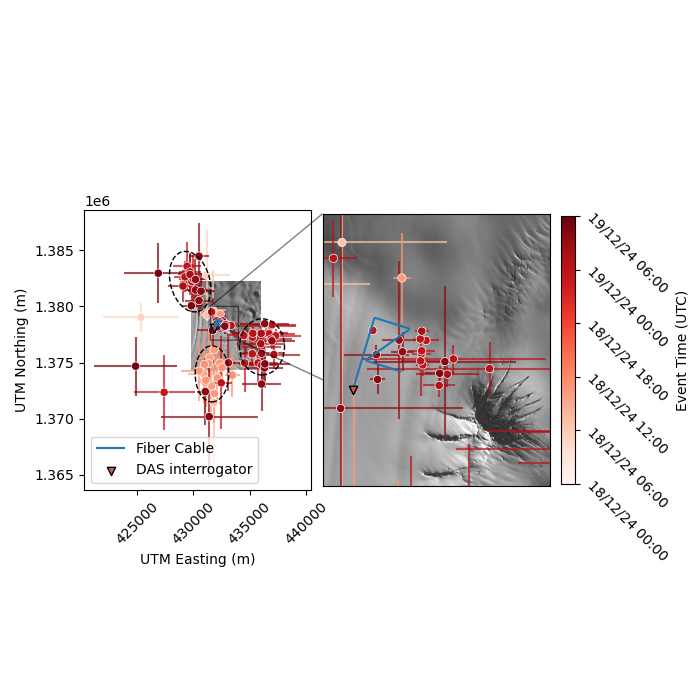

In [9]:
from matplotlib.patches import Ellipse


fig,ax=plt.subplots(figsize=(7,7))

show(image_data, transform=src.transform, ax=ax) 
ax.plot(channel_locations[:,0], channel_locations[:,1], label='Fiber Cable')

colors_plot = cmap(norm(mean_params_good[:,3]))
for i in range(mean_params_good.shape[0]):
    ax.errorbar(
        mean_params_good[i, 0],
        mean_params_good[i, 1],
        xerr=std_params_good[i, 0],
        yerr=std_params_good[i, 1],
        fmt='none',
        ecolor=colors_plot[i],
        alpha=0.7,
        zorder=0
    )
sns.scatterplot(x=mean_params_good[:,0].T,y=mean_params_good[:,1].T,  palette='Reds',hue=mean_params_good[:,3].T, hue_norm=norm, ax=ax)
ax.get_legend().remove()


plt.xticks(rotation=45)

ax.set_xlabel('UTM Easting (m)')
ax.set_ylabel('UTM Northing (m)')

axins = ax.inset_axes(
    [1.05, 0, 1, 1],
    xticks=[], 
    yticks=[]
    )

show(image_data, transform=src.transform, ax=axins) 
axins.plot(channel_locations[:,0], channel_locations[:,1])

colors_plot = cmap(norm(mean_params_good[:,3]))
for i in range(mean_params_good.shape[0]):
    axins.errorbar(
        mean_params_good[i, 0],
        mean_params_good[i, 1],
        xerr=std_params_good[i, 0],
        yerr=std_params_good[i, 1],
        fmt='none',
        ecolor=colors_plot[i],
        alpha=0.7,
        zorder=0
    )
sns.scatterplot(x=mean_params_good[:,0].T,y=mean_params_good[:,1].T,  palette='Reds',hue=mean_params_good[:,3].T, hue_norm=norm, ax=axins)
axins.get_legend().remove()
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(min_time, max_time,6), pad=.5, fraction=0.046, shrink=0.4, label='Event Time (UTC)')
cbar.ax.set_yticklabels(pd.to_datetime(np.linspace(min_time, max_time,6),  unit='s', utc=True).strftime('%d/%m/%y %H:%M'), rotation=-45)

axins.scatter(channel_locations[0,0], channel_locations[0,1],
           c='indianred', marker='v', ec='black', label='DAS interrogator', zorder=2)

ax.scatter(channel_locations[0,0], channel_locations[0,1],
           c='indianred', marker='v', ec='black', label='DAS interrogator', zorder=1)


## Areas of interesting activity
## Ellipse 1
ellipse = Ellipse(xy=(429700, 1.3822e6), angle=15,width=3500, height=5500,
                        edgecolor='black', fc='None', lw=1, ls = '--')
ax.add_patch(ellipse)

# ## Ellipse 2
ellipse = Ellipse(xy=(436100, 1.3764e6), width=4000, height=5000, 
                        edgecolor='black', fc='None', lw=1, ls = '--')
ax.add_patch(ellipse)

## Ellipse 3
ellipse = Ellipse(xy=(431650, 1.374e6), width=3000, height=5000, 
                        edgecolor='black', fc='None', lw=1, ls = '--')
ax.add_patch(ellipse)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[0], handles[-1]], labels=[labels[0], labels[-1]])

axins.set_ylim([1.377e6, 1.380e6])
axins.set_xlim([4.315e5, 4.34e5])
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()

plt.savefig('Figures/fig4.png',dpi=600)

Text(0.5, 0, 'UTM Northing (m)')

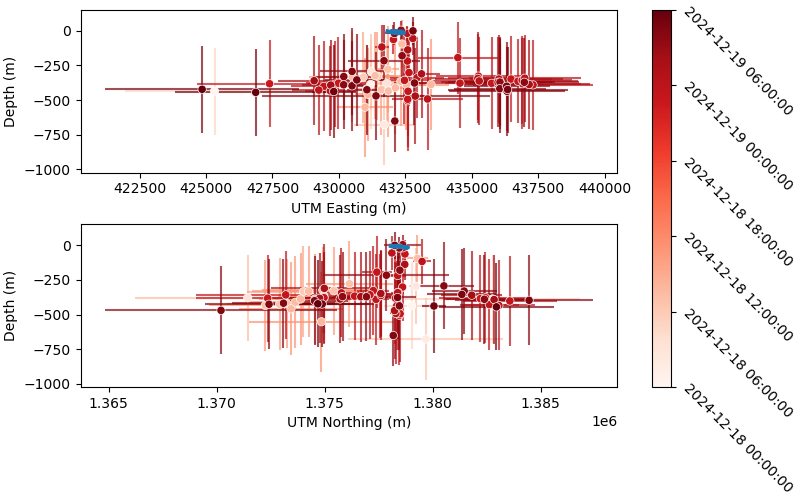

In [8]:
fig,(ax, ax1) = plt.subplots(2,1,figsize=(8,5), layout='compressed')
min_time = datetime.datetime(year=2024, month=12,day=18,hour=0, tzinfo=datetime.timezone.utc).timestamp()
max_time = datetime.datetime(year=2024, month=12,day=19,hour=6, tzinfo=datetime.timezone.utc).timestamp()

norm = plt.Normalize(min_time, max_time)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
cmap = plt.cm.Reds
colors_plot = cmap(norm(mean_params_good[:,3]))
for i in range(mean_params_good.shape[0]):
    ax.errorbar(
        mean_params_good[i, 0],
        mean_params_good[i, 2],
        xerr=std_params_good[i, 0],
        yerr=std_params_good[i, 2],
        fmt='none',
        ecolor=colors_plot[i],
        alpha=0.7,
        zorder=0
    )
    ax1.errorbar(
        mean_params_good[i, 1],
        mean_params_good[i, 2],
        xerr=std_params_good[i, 1],
        yerr=std_params_good[i, 2],
        fmt='none',
        ecolor=colors_plot[i],
        alpha=0.7,
        zorder=0
    )
    
sns.scatterplot(x=mean_params_good[:,0].T,y= mean_params_good[:,2].T,  palette='Reds',hue=mean_params_good[:,3].T,ax=ax)
sns.scatterplot(x=mean_params_good[:,1].T,y= mean_params_good[:,2].T,  palette='Reds',hue=mean_params_good[:,3].T,ax=ax1)

ax.plot(channel_locations[:,0], channel_locations[:,2], lw=3)
ax1.plot(channel_locations[:,1], channel_locations[:,2], lw=3)

ax.get_legend().remove()
ax1.get_legend().remove()
cbar = ax.figure.colorbar(sm, ax=[ax, ax1], ticks=np.linspace(min_time, max_time,6), fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(pd.to_datetime(np.linspace(min_time, max_time,6),  unit='s'), rotation=-45)

ax.set_ylabel('Depth (m)')
ax1.set_ylabel('Depth (m)')

ax.set_xlabel('UTM Easting (m)')
ax1.set_xlabel('UTM Northing (m)')